In [ ]:
# ☆ 只有第一次需要
!pip -q install lightgbm scikit-learn pandas numpy

In [ ]:
# ---- 挂载（在 Colab） ----
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print("Not in Colab or already mounted:", e)

import os, glob, collections, itertools

# 允许大/小写扩展名
PATTERN_ANY_CSV = "**/*.[cC][sS][vV]"

# 先按可能的根路径搜索
roots_to_try = [
    "/content/drive/MyDrive/INCS870/CICIoT2023",
    "/content/drive/MyDrive/INCS870",
    "/content/drive/MyDrive",
    "/content/drive"
]

found = []
for r in roots_to_try:
    if os.path.exists(r):
        found += glob.glob(os.path.join(r, PATTERN_ANY_CSV), recursive=True)

print(f"Total CSV found: {len(found)}")
# 列出前 15 个看看
for p in found[:15]:
    print("  -", p)

# 统计哪个目录下的 CSV 最多，用它当候选根
counter = collections.Counter(os.path.dirname(p) for p in found)
best_dir, best_cnt = (None, 0)
if counter:
    best_dir, best_cnt = counter.most_common(1)[0]
    print("\nLikely dataset dir (most CSVs):", best_dir, f"(~{best_cnt} CSVs here)")

# 把上层两级作为“候选根”
def up(path, n=1):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CANDIDATE_ROOTS = list(dict.fromkeys([
    best_dir,
    up(best_dir, 1) if best_dir else None,
    up(best_dir, 2) if best_dir else None
]))
CANDIDATE_ROOTS = [p for p in CANDIDATE_ROOTS if p and os.path.exists(p)]

print("\nCandidate ROOT_DIR options:")
for i, p in enumerate(CANDIDATE_ROOTS):
    print(f"  [{i}] {p}")

# 选第一个作为默认（你也可以手动复制喜欢的一个）
FOUND_ROOT = CANDIDATE_ROOTS[0] if CANDIDATE_ROOTS else None
print("\nFOUND_ROOT =", FOUND_ROOT)


Mounted at /content/drive
Total CSV found: 24
  - /content/drive/MyDrive/INCS870/CICIoT2023/Benign_final/BenignTraffic3.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/Benign_final/BenignTraffic1.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_TCP/DDoS-TCP_Flood.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_TCP/DDoS-TCP_Flood1.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_UDP/DDoS-UDP_Flood1.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_UDP/DDoS-UDP_Flood20.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/Benign_final/BenignTraffic3.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/Benign_final/BenignTraffic1.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_TCP/DDoS-TCP_Flood.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_TCP/DDoS-TCP_Flood1.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_UDP/DDoS-UDP_Flood1.pcap.csv
  - /content/drive/MyDrive/INCS870/CICIoT2023/DDos_UDP/DDoS-UDP

In [ ]:
# ===== Hotfix: 清洗 X_demo -> mRMR 选列 -> 保证 100×10 =====
import numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

NA_COL_THRESH = 0.60     # 缺失>60%的列丢弃（可调）
MIN_VAR = 1e-12          # 常数列阈值

def clean_for_mrmr(Xdf: pd.DataFrame,
                   na_col_thresh=NA_COL_THRESH,
                   min_var=MIN_VAR) -> pd.DataFrame:
    # 1) Inf→NaN
    X = Xdf.replace([np.inf, -np.inf], np.nan).copy()
    # 2) 丢弃高缺失列
    keep = X.isna().mean() <= na_col_thresh
    X = X.loc[:, keep]
    # 3) 中位数填充（数值型）
    imp = SimpleImputer(strategy='median')
    Xv = imp.fit_transform(X)
    # 4) 去常数列
    var = np.var(Xv, axis=0)
    nonconst = var > min_var
    Xv = Xv[:, nonconst]
    cols = X.columns[nonconst]
    return pd.DataFrame(Xv, columns=cols, index=Xdf.index)

X_clean = clean_for_mrmr(X_demo)

if X_clean.shape[1] == 0:
    raise RuntimeError("清洗后没有可用特征：放宽 NA_COL_THRESH，或选择别的 CSV/目录。")

# mRMR 选列（最多 10 列；如果不足 10，后面会补齐）
k_eff = min(K_FEATURES, X_clean.shape[1])
sel_idx = mrmr_select_columns(X_clean, np.array(list(y_demo)), k=k_eff, random_state=RANDOM_STATE)
X10 = X_clean.iloc[:, sel_idx].copy()
chosen_names = list(X10.columns)

# 若少于 10 列，用剩余列按互信息降序补齐到 10（仅为演示凑满 shape）
if X10.shape[1] < K_FEATURES:
    from sklearn.feature_selection import mutual_info_classif
    rest = [c for c in X_clean.columns if c not in chosen_names]
    if rest:
        mi_rest = mutual_info_classif(X_clean[rest].values, np.array(list(y_demo)), random_state=RANDOM_STATE)
        order = np.argsort(mi_rest)[::-1].tolist()
        need = K_FEATURES - X10.shape[1]
        extra = [rest[i] for i in order[:need]]
        X10 = pd.concat([X10, X_clean[extra]], axis=1)
        chosen_names += extra

# 标准化
scaler = StandardScaler()
X10[:] = scaler.fit_transform(X10.values)

print(f"After cleaning: {X_clean.shape}")
print(f"DEMO shape: {X10.shape}  (expect {(min(N_ROWS_DEMO,len(X10)), K_FEATURES)})")
print("Top-10 features (filled if needed):", chosen_names)
display(X10.head())

After cleaning: (425317, 36)
DEMO shape: (425317, 10)  (expect (100, 10))
Top-10 features (filled if needed): ['Std', 'Rate', 'Variance', 'Tot size', 'IAT', 'AVG', 'Time_To_Live', 'Number', 'Tot sum', 'IRC']


,Std,Rate,Variance,Tot size,IAT,AVG,Time_To_Live,Number,Tot sum,IRC
50816,-0.157831,-0.097007,-0.259984,-0.573224,-0.242103,-0.573224,1.089074,0.022201,-0.573438,-0.039063
348478,-0.601398,-0.101278,-0.349756,-0.710001,1.840613,-0.710001,-0.690304,0.022201,-0.710465,-0.039063
214730,-0.819871,-0.099922,-0.363848,-0.851295,0.438211,-0.851295,1.584524,0.022201,-0.852016,-0.039063
386815,-0.770433,-0.099311,-0.362399,-0.756905,0.481514,-0.756905,-1.079724,0.022201,-0.757455,-0.039063
396464,-0.861874,-0.077908,-0.364278,-0.874455,-0.780750,-0.874455,1.532473,0.022201,-0.875219,-0.039063


In [ ]:
# =================== 1) Imports & Config ===================
import os, glob, warnings
import numpy as np, pandas as pd
from typing import List, Optional, Dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

ROOT_DIR        = "/content/drive/MyDrive/INCS870/CICIoT2023"   # ← 改成你的真实目录
GLOB_PATTERN    = "**/*.[cC][sS][vV]"     # 兼容 .csv/.CSV
MAX_FILES       = 2
N_ROWS_DEMO     = 100
K_FEATURES      = 10
RANDOM_STATE    = 42

TARGET_CANDIDATES = ["Label","label","class","Class","attack","Attack","target","y"]
CLASS_WHITELIST   = None   # 例如 ["BENIGN","TCP","UDP"]；不指定则自动选择高频类
AUTO_TOPK         = 3      # 自动保留的高频类（>=2样本）

# =================== 2) Helpers ===================
def smart_read_csv(path: str) -> pd.DataFrame:
    for kw in (dict(), dict(sep=";"), dict(engine="python")):
        try:
            return pd.read_csv(path, low_memory=False, **kw)
        except Exception:
            pass
    raise RuntimeError(f"Cannot read CSV: {path}")

def load_small_df(root_dir: str, pattern="**/*.[cC][sS][vV]", max_files=2) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(root_dir, pattern), recursive=True))
    if not files:
        raise FileNotFoundError(f"No CSV found under: {root_dir}")
    print(f"Found {len(files)} CSVs under {root_dir}. Using first {min(max_files,len(files))}.")
    dfs = [smart_read_csv(f) for f in files[:max_files]]
    common = set(dfs[0].columns)
    for d in dfs[1:]:
        common &= set(d.columns)
    if not common:
        raise RuntimeError("Selected files share no common columns.")
    return pd.concat([d[list(common)].copy() for d in dfs], ignore_index=True)

def find_label_col(df: pd.DataFrame, cands: List[str]) -> Optional[str]:
    for c in cands:
        if c in df.columns: return c
    last = df.columns[-1]
    if 1 < df[last].nunique(dropna=True) <= max(20, int(0.05*len(df))):
        return last
    return None

def clean_for_mrmr(Xdf: pd.DataFrame, na_col_thresh=0.60, min_var=1e-12) -> pd.DataFrame:
    X = Xdf.replace([np.inf, -np.inf], np.nan).copy()
    keep = X.isna().mean() <= na_col_thresh
    X = X.loc[:, keep]
    imp = SimpleImputer(strategy='median')
    Xv = imp.fit_transform(X)
    var = np.var(Xv, axis=0)
    nonconst = var > min_var
    Xv = Xv[:, nonconst]
    cols = X.columns[nonconst]
    return pd.DataFrame(Xv, columns=cols, index=X.index)

def mrmr_select_columns(X_df, y, k: int, random_state=42):
    X = X_df.values
    Ixy = mutual_info_classif(X, y, discrete_features='auto', random_state=random_state)
    C = np.corrcoef(X, rowvar=False)
    C = np.abs(np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0))
    np.fill_diagonal(C, 0.0)
    selected, candidates = [], list(range(X.shape[1]))
    for _ in range(min(k, X.shape[1])):
        best, best_val = None, -1e18
        for j in candidates:
            red = C[j, selected].mean() if selected else 0.0
            score = Ixy[j] - red
            if score > best_val:
                best, best_val = j, score
        selected.append(best)
        candidates.remove(best)
    return selected

# =================== 3) Load + label prep ===================
df_all = load_small_df(ROOT_DIR, GLOB_PATTERN, MAX_FILES).dropna(axis=1, how="all")
target_col = find_label_col(df_all, TARGET_CANDIDATES)
if target_col is None:
    raise RuntimeError("Cannot find target column; set target_col manually.")

feature_df_full = df_all.drop(columns=[target_col])
feature_df_num  = feature_df_full.select_dtypes(include=[np.number])
if feature_df_num.shape[1] == 0:
    feature_df_num = pd.get_dummies(feature_df_full, drop_first=False)

labels = df_all[target_col].astype(str)

# 手动白名单优先，否则选 Top-K 高频类（每类≥2）
if CLASS_WHITELIST is not None:
    mask = labels.isin(CLASS_WHITELIST)
    feature_df_num = feature_df_num.loc[mask].reset_index(drop=True)
    labels = labels.loc[mask].reset_index(drop=True)
vc = labels.value_counts()
eligible = vc[vc >= 2].index.tolist()
if len(eligible) >= 2 and CLASS_WHITELIST is None:
    topk = vc.loc[eligible].head(AUTO_TOPK).index.tolist()
    mask = labels.isin(topk)
    feature_df_num = feature_df_num.loc[mask].reset_index(drop=True)
    labels = labels.loc[mask].reset_index(drop=True)

le = LabelEncoder()
y_all = le.fit_transform(labels.values)

# =================== 4) 先抽样（这一步修正：取第一个返回值就是“demo索引”） ===================
N = min(N_ROWS_DEMO, len(feature_df_num))
demo_idx, _, y_demo, _ = train_test_split(
    np.arange(len(feature_df_num)), y_all, train_size=N,
    stratify=y_all if len(np.unique(y_all))>1 else None,
    random_state=RANDOM_STATE
)
X_demo = feature_df_num.iloc[demo_idx].copy()
print(f"Sampled demo rows: {len(X_demo)} (target {N_ROWS_DEMO})")

# =================== 5) 清洗 -> mRMR -> 标准化 ===================
X_clean = clean_for_mrmr(X_demo)
if X_clean.shape[1] == 0:
    raise RuntimeError("No usable features after cleaning; loosen thresholds or pick other CSVs.")

sel_idx = mrmr_select_columns(X_clean, y_demo, k=K_FEATURES, random_state=RANDOM_STATE)
X10 = X_clean.iloc[:, sel_idx].copy()
chosen = list(X10.columns)

# 若不足 10 列，用互信息补满到 10（演示友好）
if X10.shape[1] < K_FEATURES:
    rest = [c for c in X_clean.columns if c not in chosen]
    if rest:
        mi_rest = mutual_info_classif(X_clean[rest].values, y_demo, random_state=RANDOM_STATE)
        order = np.argsort(mi_rest)[::-1].tolist()
        need = K_FEATURES - X10.shape[1]
        extra = [rest[i] for i in order[:need]]
        X10 = pd.concat([X10, X_clean[extra]], axis=1)
        chosen += extra

scaler = StandardScaler()
X10[:] = scaler.fit_transform(X10.values)

# =================== 6) 输出 ===================
print(f"\nDEMO shape: {X10.shape}  (expect {(N_ROWS_DEMO, K_FEATURES)})")
print("Top-10 features:", chosen)
print("\nClass distribution in DEMO:")
vals, cnts = np.unique(y_demo, return_counts=True)
for v, c in zip(vals, cnts):
    print(f"  {le.inverse_transform([v])[0]}: {c}")

display(X10.head())




Found 6 CSVs under /content/drive/MyDrive/INCS870/CICIoT2023. Using first 2.
Sampled demo rows: 100 (target 100)

DEMO shape: (100, 10)  (expect (100, 10))
Top-10 features: ['IAT', 'Rate', 'Variance', 'HTTP', 'IGMP', 'DHCP', 'Tot sum', 'DNS', 'ICMP', 'SSH']

Class distribution in DEMO:
  0.0: 39
  0.1: 36
  0.2: 25


,IAT,Rate,Variance,HTTP,IGMP,DHCP,Tot sum,DNS,ICMP,SSH
16887,-0.768927,-0.110874,0.012841,-0.15668,-0.100504,-0.19245,2.051136,-0.315311,-0.239957,-0.100504
172798,0.181712,-0.133235,-0.410945,-0.15668,-0.100504,-0.19245,-0.656409,6.208356,-0.239957,-0.100504
136310,-0.837577,0.033223,-0.416314,-0.15668,-0.100504,-0.19245,-0.761412,-0.315311,-0.239957,-0.100504
143775,-0.408192,-0.131110,-0.416312,-0.15668,-0.100504,-0.19245,-0.762932,-0.315311,3.187999,-0.100504
71264,-0.762344,0.383265,-0.416314,-0.15668,-0.100504,-0.19245,-0.761412,-0.315311,-0.239957,-0.100504


In [ ]:
# =================== 1) EFB 独立函数（手工分组 + 偏移合并） ===================
import numpy as np, pandas as pd

def group_by_prefix(columns: List[str], sep="_", min_group_size=2) -> List[List[int]]:
    """
    简单的“语义分组”示例：按前缀分组（不做贪心搜索）
    例如：['proto_TCP','proto_UDP','flag_SYN','flag_ACK','flow_x'] →
        [['proto_TCP','proto_UDP'], ['flag_SYN','flag_ACK']]，单个特征不分组
    """
    buckets: Dict[str, List[int]] = {}
    for idx, name in enumerate(columns):
        if sep in name:
            prefix = name.split(sep, 1)[0]
            buckets.setdefault(prefix, []).append(idx)
    groups = [idxs for idxs in buckets.values() if len(idxs) >= min_group_size]
    return groups

def efb_pack_offset(X_df: pd.DataFrame, groups: List[List[int]]):
    """
    不找最优 bundle；完全按给定 groups 做“偏移合并”可逆近似演示：
    - 同组特征在不同区间（offset）避免覆盖冲突
    - 返回 packed_df 及反向映射 inv_map（用于解包）
    """
    X = X_df.values
    packed_cols = []
    inv_map = []
    used = set(j for g in groups for j in g)

    # 组内合并
    for g in groups:
        offset = 0.0
        col = np.zeros((X.shape[0],), dtype=float)
        details = []
        for j in g:
            xj = X[:, j]
            # 估一个安全偏移（这里用列的 max-min 范围 + 1.0，演示即可）
            rng = np.nanmax(xj) - np.nanmin(xj)
            safe = (rng if np.isfinite(rng) else 0.0) + 1.0
            col = col + (xj + offset)
            details.append((j, offset, safe))
            offset += safe
        packed_cols.append(col)
        inv_map.append(details)

    # 未分组的列原样带上
    remain = [j for j in range(X_df.shape[1]) if j not in used]
    packed_cols.extend([X[:, j] for j in remain])
    inv_map.extend([[(j, 0.0, 0.0)] for j in remain])

    packed = np.vstack(packed_cols).T
    out_cols = [f"efb_{i}" for i in range(len(groups))] + [X_df.columns[j] for j in remain]
    return pd.DataFrame(packed, columns=out_cols, index=X_df.index), inv_map

def efb_unpack_offset(packed_df: pd.DataFrame, inv_map):
    """
    仅用于演示的近似解包（严格可逆需记录分箱/桶边界，这里只展示 I/O 过程）
    """
    P = packed_df.values
    recovered: Dict[int, np.ndarray] = {}
    for k, details in enumerate(inv_map):
        base = P[:, k].copy()
        for j, off, safe in details:
            recovered[j] = np.clip(base - off, a_min=None, a_max=base.max())  # 近似
    # 按原索引顺序组回
    cols = [recovered[j] for j in sorted(recovered)]
    return pd.DataFrame(np.vstack(cols).T)

# =================== 2) 选择路径：A.内置 EFB  or  B.独立 I/O 演示 ===================
USE_LIGHTGBM_EFB = True   # ☆ 若你想演示手工 I/O，请设为 False

import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, recall_score

if USE_LIGHTGBM_EFB:
    # ------- A) LightGBM 训练（内置 EFB 自动处理互斥稀疏列） -------
    dtrain = lgb.Dataset(X10, label=y_demo, free_raw_data=False)
    num_class = len(np.unique(y_demo))
    params = {
        "objective": "multiclass" if num_class>2 else "binary",
        "num_class": num_class if num_class>2 else 1,
        "learning_rate": 0.1,
        "num_leaves": 31,
        "max_bin": 63,           # 小 demo 用更小桶，训练更快
        "verbosity": -1,
        "metric": "multi_logloss" if num_class>2 else "binary_logloss",
        # 其它 LightGBM 默认就会启用基于直方图的流程，EFB/GOSS 属于内部实现细节，无需手动开关
    }
    model = lgb.train(params, dtrain, num_boost_round=50)
    # 自评估（train 上快速过一遍）
    pred = model.predict(X10)
    y_hat = pred.argmax(1) if num_class>2 else (pred.ravel()>0.5).astype(int)
    print("== LightGBM(EFB内置) on DEMO ==")
    print("Acc:", accuracy_score(y_demo, y_hat))
    print("F1 :", f1_score(y_demo, y_hat, average="macro"))
    print("Rec:", recall_score(y_demo, y_hat, average="macro"))
else:
    # ------- B) 独立 EFB I/O 演示（不依赖贪心）+ LightGBM 训练 -------
    # 1) 基于“前缀”做语义分组（示例：以 '_' 为分隔符）
    groups = group_by_prefix(list(X10.columns), sep="_", min_group_size=2)
    print(f"[EFB] semantic groups (no greedy): {groups if groups else 'None'}")

    # 2) 偏移合并（I/O 演示）
    X_packed, inv_map = efb_pack_offset(X10, groups)
    print("Packed shape:", X_packed.shape, "from", X10.shape)

    # 3) （可选）解包近似验证
    X_recovered = efb_unpack_offset(X_packed, inv_map)
    print("Recovered shape:", X_recovered.shape)

    # 4) 用打包后的特征训练 LightGBM（只是演示可行性）
    dtrain = lgb.Dataset(X_packed, label=y_demo, free_raw_data=False)
    num_class = len(np.unique(y_demo))
    params = {
        "objective": "multiclass" if num_class>2 else "binary",
        "num_class": num_class if num_class>2 else 1,
        "learning_rate": 0.1,
        "num_leaves": 31,
        "max_bin": 63,
        "verbosity": -1,
        "metric": "multi_logloss" if num_class>2 else "binary_logloss",
    }
    model = lgb.train(params, dtrain, num_boost_round=50)
    pred = model.predict(X_packed)
    y_hat = pred.argmax(1) if num_class>2 else (pred.ravel()>0.5).astype(int)
    print("== LightGBM(on EFB-packed) on DEMO ==")
    print("Acc:", accuracy_score(y_demo, y_hat))
    print("F1 :", f1_score(y_demo, y_hat, average="macro"))
    print("Rec:", recall_score(y_demo, y_hat, average="macro"))


== LightGBM(EFB内置) on DEMO ==
Acc: 0.83
F1 : 0.8317845978971299
Rec: 0.8339316239316239


In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
import lightgbm as lgb

# y_demo 是数值编码；le 是上个模块里的 LabelEncoder
name_map = {i: le.inverse_transform([i])[0] for i in np.unique(y_demo)}

X_tr, X_te, y_tr, y_te = train_test_split(
    X10, y_demo, test_size=0.2, stratify=y_demo, random_state=42
)

clf = lgb.LGBMClassifier(objective="multiclass" if len(name_map)>2 else "binary",
                         num_class=len(name_map) if len(name_map)>2 else None,
                         learning_rate=0.1, num_leaves=31, max_bin=63, n_estimators=80)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_te)
print("Hold-out (20%) ⇒")
print(" Acc :", accuracy_score(y_te, y_pred))
print(" F1  :", f1_score(y_te, y_pred, average="macro"))
print(" Rec :", recall_score(y_te, y_pred, average="macro"))

# 混淆矩阵（带标签名）
labels_sorted = sorted(name_map.keys())
cm = confusion_matrix(y_te, y_pred, labels=labels_sorted)
cm_df = pd.DataFrame(cm, index=[name_map[i] for i in labels_sorted],
                        columns=[name_map[i] for i in labels_sorted])
cm_df


Hold-out (20%) ⇒
 Acc : 0.4
 F1  : 0.32598039215686275
 Rec : 0.3511904761904762


,0.0,0.1,0.2
0.0,5,2,1
0.1,3,3,1
0.2,0,5,0


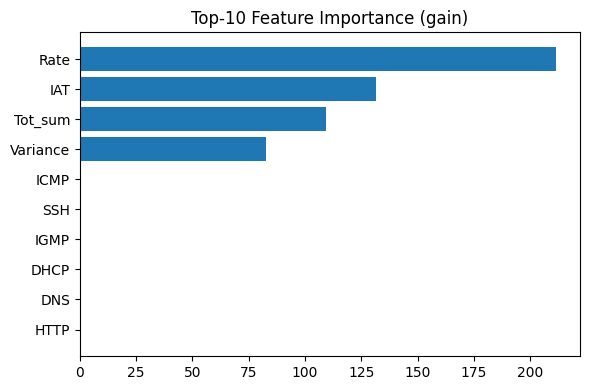

In [ ]:
import matplotlib.pyplot as plt
imp = clf.booster_.feature_importance(importance_type="gain")
feat_names = clf.booster_.feature_name()

# 排序后取前 10
order = np.argsort(imp)[::-1]
plt.figure(figsize=(6,4))
plt.barh([feat_names[i] for i in order[:10]][::-1],
         [imp[i] for i in order[:10]][::-1])
plt.title("Top-10 Feature Importance (gain)")
plt.tight_layout()
plt.show()


Hold-out Acc/F1/Rec: 0.45 0.37 0.399


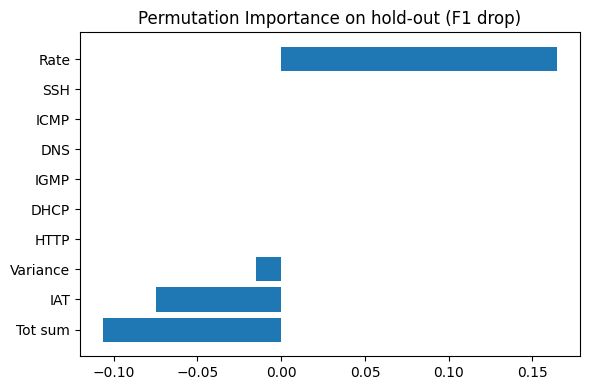

5-fold accuracy: mean=0.590, std=0.080
5-fold f1_macro: mean=0.555, std=0.095
5-fold recall_macro: mean=0.581, std=0.084


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# 1) 80/20 验证
X_tr, X_te, y_tr, y_te = train_test_split(
    X10, y_demo, test_size=0.2, stratify=y_demo, random_state=42
)

clf = lgb.LGBMClassifier(
    objective="multiclass" if len(np.unique(y_demo))>2 else "binary",
    num_class=len(np.unique(y_demo)) if len(np.unique(y_demo))>2 else None,
    learning_rate=0.1, num_leaves=31, max_bin=63,
    n_estimators=120, random_state=42
)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_te)
print("Hold-out Acc/F1/Rec:",
      round(accuracy_score(y_te, y_pred), 3),
      round(f1_score(y_te, y_pred, average="macro"), 3),
      round(recall_score(y_te, y_pred, average="macro"), 3))

# 2) 置换重要性（用验证集）
pi = permutation_importance(
    clf, X_te, y_te, n_repeats=20, random_state=42, scoring="f1_macro"
)
order = np.argsort(pi.importances_mean)[::-1]

# —— 这里用 X_te.columns，避免 lightgbm 版本差异
feat_names = list(getattr(X_te, "columns", [f"f{i}" for i in range(X_te.shape[1])]))
labels = [feat_names[i] for i in order]
vals = pi.importances_mean[order]

plt.figure(figsize=(6,4))
plt.barh(labels[:10][::-1], vals[:10][::-1])
plt.title("Permutation Importance on hold-out (F1 drop)")
plt.tight_layout(); plt.show()

# 3) 5 折交叉验证（更稳的总体评估）
base = lgb.LGBMClassifier(
    objective="multiclass" if len(np.unique(y_demo))>2 else "binary",
    num_class=len(np.unique(y_demo)) if len(np.unique(y_demo))>2 else None,
    learning_rate=0.1, num_leaves=31, max_bin=63,
    n_estimators=120, random_state=42
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for metric in ["accuracy", "f1_macro", "recall_macro"]:
    cv = cross_val_score(base, X10, y_demo, cv=skf, scoring=metric)
    print(f"5-fold {metric}: mean={cv.mean():.3f}, std={cv.std():.3f}")


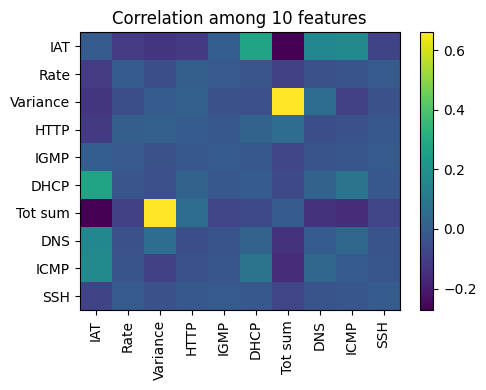

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

corr = np.corrcoef(X10.values, rowvar=False)
np.fill_diagonal(corr, 0.0)
plt.figure(figsize=(5,4))
plt.imshow(corr, aspect='auto'); plt.colorbar(); plt.title("Correlation among 10 features")
plt.xticks(range(len(X10.columns)), X10.columns, rotation=90)
plt.yticks(range(len(X10.columns)), X10.columns)
plt.tight_layout(); plt.show()


Features used (gain>0): [('IAT', 367), ('Rate', 409), ('Variance', 202), ('Tot_sum', 266)]
Used 4/10 features.


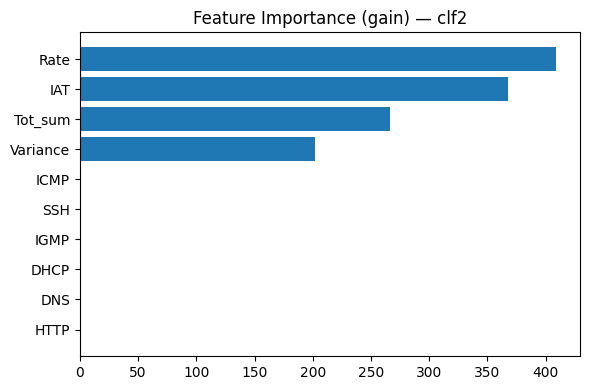

In [ ]:
# --- 3C（修正版）：促使模型多用些特征 + 看哪些被用到 ---
import lightgbm as lgb
import numpy as np

clf2 = lgb.LGBMClassifier(
    objective="multiclass" if len(np.unique(y_demo))>2 else "binary",
    num_class=len(np.unique(y_demo)) if len(np.unique(y_demo))>2 else None,
    learning_rate=0.05,
    n_estimators=300,
    num_leaves=31,
    max_bin=63,
    feature_fraction=0.7,     # 每棵树随机抽 70% 特征
    bagging_fraction=0.8,     # 每棵树随机抽 80% 样本
    bagging_freq=1,
    random_state=1,
    verbosity=-1              # 关闭内部输出（在 sklearn wrapper 里放到构造器）
)

# 用 callbacks 来控制日志（而不是 verbose=...）
clf2.fit(
    X_tr, y_tr,
    eval_set=[(X_te, y_te)],
    callbacks=[lgb.log_evaluation(period=0)]  # 不打印每轮日志
)

# 特征重要性 & 被使用到的特征（gain > 0）
imp = clf2.booster_.feature_importance(importance_type="gain")
names = clf2.booster_.feature_name()   # 注意是方法，不是属性
used = [(n, int(i)) for n, i in zip(names, imp) if i > 0]

print(f"Features used (gain>0): {used}")
print(f"Used {len(used)}/{len(names)} features.")

import matplotlib.pyplot as plt
order = np.argsort(imp)[::-1]
topn = min(10, len(names))
plt.figure(figsize=(6,4))
plt.barh([names[i] for i in order[:topn]][::-1],
         [imp[i] for i in order[:topn]][::-1])
plt.title("Feature Importance (gain) — clf2")
plt.tight_layout(); plt.show()

